In [4]:
%load_ext autoreload
%autoreload 2

# Configuration

In [5]:
dataset = "webui"
task = "text"
input_format = "seq"
output_format = "html"
add_unk_token = False
add_index_token = False
add_sep_token = True
candidate_size = -1  # -1 represents the complete training set
num_prompt = 10

# Process raw data

In [7]:
import os

from preprocess import create_processor
from utils import RAW_DATA_PATH, read_pt, write_pt, read_json
from tqdm import tqdm


processor = create_processor(dataset=dataset, task=task)
base_dir = os.path.dirname(os.getcwd())


def get_processed_data(split):
    filename = os.path.join(
        base_dir, "dataset", dataset, "processed", task, f"{split}.pt"
    )
    if os.path.exists(filename):
        processed_data = read_pt(filename)
    else:
        processed_data = []
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        raw_path = os.path.join(RAW_DATA_PATH(dataset), f"{split}.json")
        raw_data = read_json(raw_path)
        for rd in tqdm(raw_data, desc=f"{split} data processing..."):
            processed_data.append(processor(rd))
        write_pt(filename, processed_data)
    return processed_data


processed_train_data = get_processed_data("train")
processed_val_data = get_processed_data("val")
processed_test_data = get_processed_data("test")

test data processing...: 100%|██████████| 487/487 [00:04<00:00, 111.30it/s]


# Dynamic exemplar selection

In [33]:
from selection import create_selector


selector = create_selector(
    task=task,
    train_data=processed_train_data,
    candidate_size=candidate_size,
    num_prompt=num_prompt,
)

test_idx = 0
exemplars = selector(processed_test_data[test_idx])

# Input-output serialization

In [34]:
from serialization import create_serializer, build_prompt


serializer = create_serializer(
    dataset=dataset,
    task=task,
    input_format=input_format,
    output_format=output_format,
    add_index_token=add_index_token,
    add_sep_token=add_sep_token,
    add_unk_token=add_unk_token,
)
prompt = build_prompt(serializer, exemplars, processed_test_data[test_idx], dataset)

# Call GPT

In [35]:
model = "text-davinci-003"
temperature = 0.7
max_tokens = 1200
top_p = 1
frequency_penalty = 0
presence_penalty = 0
num_return = 10
stop_token = "\n\n"
os.environ["OPENAI_API_KEY"] = ""  # your api key

In [36]:
from openai import OpenAI


client = OpenAI()

response = client.completions.create(
    model=model,
    prompt=prompt,
    temperature=temperature,
    max_tokens=max_tokens,
    top_p=top_p,
    frequency_penalty=frequency_penalty,
    presence_penalty=presence_penalty,
    n=num_return,
    stop=[stop_token],
)

# Parsing

In [37]:
from parsing import Parser


parser = Parser(dataset=dataset, output_format=output_format)
parsed_response = parser(response)
print(f"filter {num_return - len(parsed_response)} invalid response")

filter 0 invalid response


# Layout ranking

In [38]:
from ranker import Ranker


ranker = Ranker()
ranked_response = ranker(parsed_response)

# Visualization

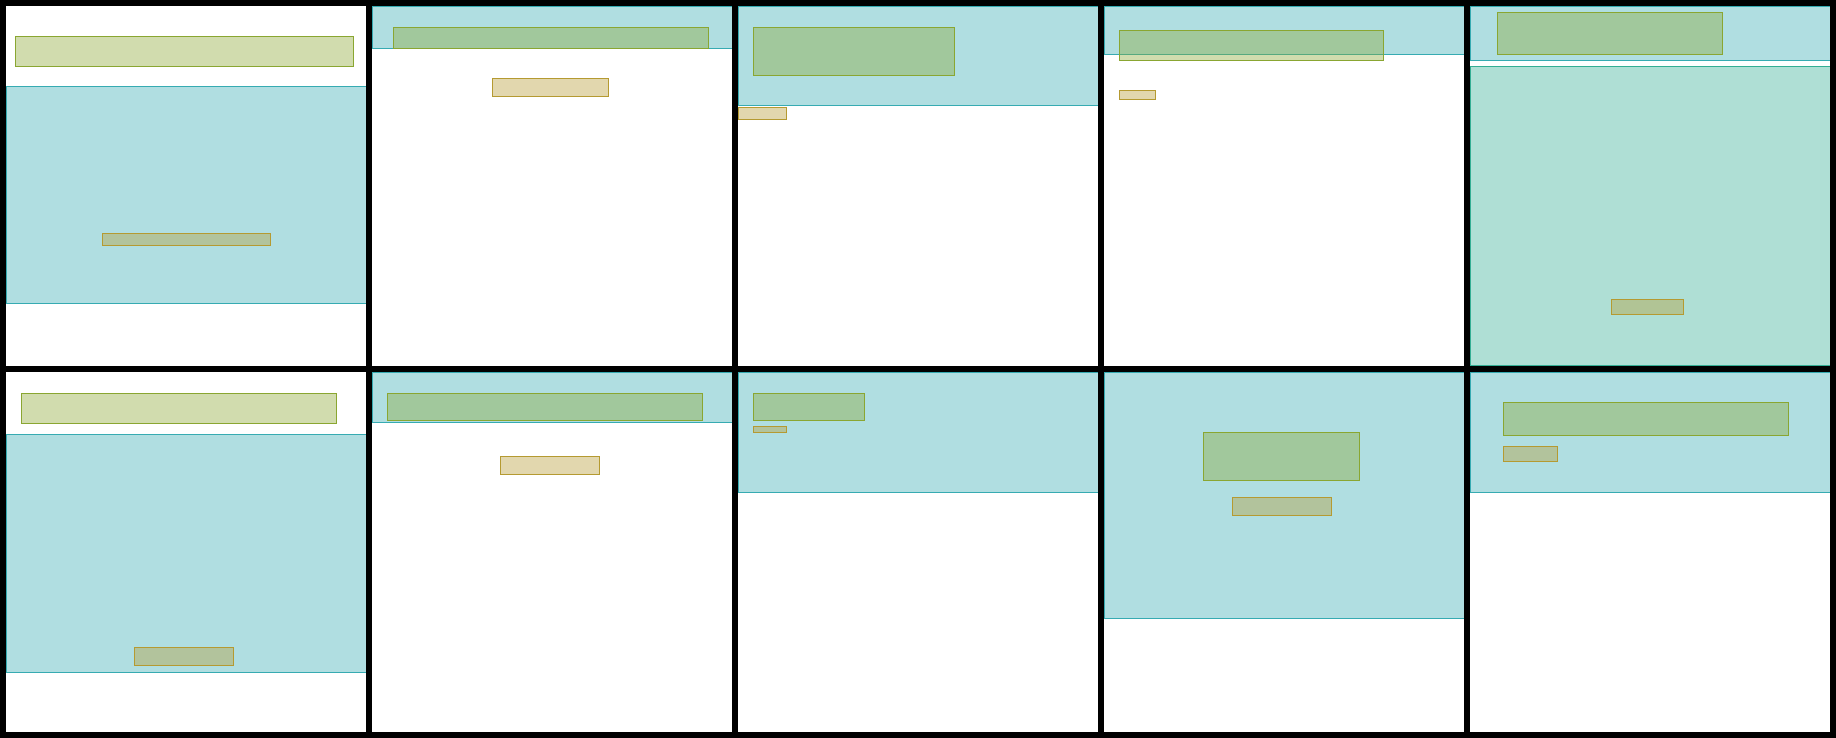

In [39]:
from visualization import Visualizer, create_image_grid


visualizer = Visualizer(dataset)
images = visualizer(ranked_response)
create_image_grid(images)